<h1>Проект Flight Delay<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовительные-работы" data-toc-modified-id="Подготовительные-работы-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовительные работы</a></span></li><li><span><a href="#Найдем-аэропорт-с-минимальной-задержкой-вылета" data-toc-modified-id="Найдем-аэропорт-с-минимальной-задержкой-вылета-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Найдем аэропорт с минимальной задержкой вылета</a></span></li><li><span><a href="#Найдем-самую-пунктуальную-авиакомпанию-на-прилет-в-LA-International-Airport" data-toc-modified-id="Найдем-самую-пунктуальную-авиакомпанию-на-прилет-в-LA-International-Airport-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Найдем самую пунктуальную авиакомпанию на прилет в LA International Airport</a></span></li><li><span><a href="#Найдем-аэропорт,-где-самолёты-проводят-больше-всего-времени-на-рулении-(среднее-значение)" data-toc-modified-id="Найдем-аэропорт,-где-самолёты-проводят-больше-всего-времени-на-рулении-(среднее-значение)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Найдем аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)</a></span></li><li><span><a href="#Построим-модель-которая-будет-выбирать-топ-3-аэропорта-прилета(вероятность-опоздания-минимальная-–-RMSE-метрика),-в-зависимости-от-аэропорта-вылета" data-toc-modified-id="Построим-модель-которая-будет-выбирать-топ-3-аэропорта-прилета(вероятность-опоздания-минимальная-–-RMSE-метрика),-в-зависимости-от-аэропорта-вылета-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Построим модель которая будет выбирать топ 3 аэропорта прилета(вероятность опоздания минимальная – RMSE метрика), в зависимости от аэропорта вылета</a></span></li></ul></div>

# Подготовительные работы

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
resulting_data = joblib.load('resulting_data.pkl')

In [4]:
resulting_data.head(3)

,YEAR,MONTH,DAY,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,TAXI_IN,ARRIVAL_DELAY,AIRLINE,O_AIRPORT,O_CITY,dDATE,D_AIRPORT,D_CITY
15,2015,1,2,108,ANC,SEA,0.0,19.0,4.0,-15.0,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Anchorage,2015-01-02,Seattle-Tacoma International Airport,Seattle
23,2015,1,2,120,ANC,SEA,7.0,9.0,11.0,-5.0,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Anchorage,2015-01-02,Seattle-Tacoma International Airport,Seattle
24,2015,1,2,92,ANC,SEA,9.0,10.0,8.0,-11.0,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Anchorage,2015-01-02,Seattle-Tacoma International Airport,Seattle


In [5]:
resulting_data.columns

Index(['YEAR', 'MONTH', 'DAY', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'DEPARTURE_DELAY', 'TAXI_OUT', 'TAXI_IN',
       'ARRIVAL_DELAY', 'AIRLINE', 'O_AIRPORT', 'O_CITY', 'dDATE', 'D_AIRPORT',
       'D_CITY'],
      dtype='object')

_________________________________________________________

# Найдем аэропорт с минимальной задержкой вылета 

In [6]:
# Сделаем расчет средней задержки по аэропортам
average_delay_by_airport = (resulting_data.groupby('O_AIRPORT')['DEPARTURE_DELAY'].mean().reset_index())

In [7]:
# Найдем аэропорт с минимальной средней задержкой
min_delay_info = average_delay_by_airport.loc[average_delay_by_airport['DEPARTURE_DELAY'].idxmin()]

In [8]:
min_delay_airport = min_delay_info['O_AIRPORT']

In [9]:
min_delay_value = min_delay_info['DEPARTURE_DELAY']

In [10]:
min_delay_city = resulting_data.loc[resulting_data['O_AIRPORT'] == min_delay_airport, 'O_CITY'].values[0]

In [11]:
print(f'Аэропорт с минимальной средней задержкой вылета: {min_delay_airport}, который находится в {min_delay_city}.')
print(f'Средняя задержка вылета: {min_delay_value:.2f} минут.')

Аэропорт с минимальной средней задержкой вылета: Lewiston-Nez Perce County Airport, который находится в Lewiston.
Средняя задержка вылета: 8.46 минут.


In [12]:
# Построим временной ряд по метрике «Средняя задержка по месяцам» для аэропорта с минимальной задержкой вылета:
monthly_delay = (resulting_data[resulting_data['O_AIRPORT'] == min_delay_airport]
                 .groupby(resulting_data['dDATE'].dt.to_period('M'))['DEPARTURE_DELAY'].mean().reset_index())

monthly_delay['dDATE'] = monthly_delay['dDATE'].dt.to_timestamp()

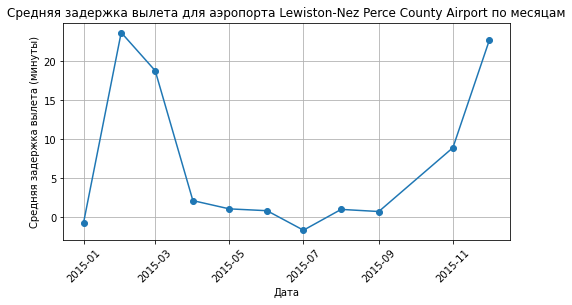

In [13]:
# Визуализируем среднюю задержку по месяцам
plt.figure(figsize=(8, 4))
plt.plot(monthly_delay['dDATE'], monthly_delay['DEPARTURE_DELAY'], marker='o')
plt.title(f'Средняя задержка вылета для аэропорта {min_delay_airport} по месяцам')
plt.xlabel('Дата')
plt.ylabel('Средняя задержка вылета (минуты)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

**Анализируя график, можно сделать вывод, что средняя задержка вылетов возрастает в зимние месяцы, что может быть связано с ухудшением погодных условий в это время года в г. Льюистон, штат Айдахо.**

____________________________________________

# Найдем самую пунктуальную авиакомпанию на прилет в LA International Airport

In [14]:
# Фильтруем рейсы, прилетающие в Лос-Анджелес
la_flights = resulting_data[resulting_data['DESTINATION_AIRPORT'] == 'LAX']
la_flights.head(3)

,YEAR,MONTH,DAY,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,TAXI_IN,ARRIVAL_DELAY,AIRLINE,O_AIRPORT,O_CITY,dDATE,D_AIRPORT,D_CITY
797154,2015,1,4,150,ANC,LAX,134.0,9.0,16.0,111.0,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Anchorage,2015-01-04,Los Angeles International Airport,Los Angeles
797155,2015,1,8,150,ANC,LAX,-4.0,19.0,22.0,25.0,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Anchorage,2015-01-08,Los Angeles International Airport,Los Angeles
797158,2015,1,11,150,ANC,LAX,1.0,19.0,6.0,-27.0,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Anchorage,2015-01-11,Los Angeles International Airport,Los Angeles


In [15]:
# Группируем по авиакомпаниям и находим среднюю задержку прилета
arrival_delay = la_flights.groupby('AIRLINE')['ARRIVAL_DELAY'].mean().reset_index()
arrival_delay.head(3)

,AIRLINE,ARRIVAL_DELAY
0,Alaska Airlines Inc.,14.993110
1,American Airlines Inc.,20.698266
2,American Eagle Airlines Inc.,44.712766


In [16]:
# Находим самую пунктуальную авиакомпанию
most_punctual_airline = arrival_delay.loc[arrival_delay['ARRIVAL_DELAY'].idxmin()]

In [17]:
print(f"Самая пунктуальная авиакомпания, прилетающая в Лос-Анджелес - {most_punctual_airline['AIRLINE']}")
print(f"Средняя задержка рейсов авиакомпании составляет {most_punctual_airline['ARRIVAL_DELAY']:.2f} минут.")

Самая пунктуальная авиакомпания, прилетающая в Лос-Анджелес - Hawaiian Airlines Inc.
Средняя задержка рейсов авиакомпании составляет 8.25 минут.


**Посмотрим процент рейсов самой пунктуальной авиакомпании, прибывших вовремя**

In [18]:
# Фильтруем рейсы самой пунктуальной авиакомпании
punctual_airline_flights = la_flights[la_flights['AIRLINE'] == most_punctual_airline['AIRLINE']]

In [19]:
punctual_airline_flights.columns

Index(['YEAR', 'MONTH', 'DAY', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'DEPARTURE_DELAY', 'TAXI_OUT', 'TAXI_IN',
       'ARRIVAL_DELAY', 'AIRLINE', 'O_AIRPORT', 'O_CITY', 'dDATE', 'D_AIRPORT',
       'D_CITY'],
      dtype='object')

In [20]:
# Добавляем столбец для определения пунктуальности (менее 15 минут задержки)
punctual_airline_flights['ON_TIME'] = punctual_airline_flights['ARRIVAL_DELAY'] < 15

C:\Users\acer\AppData\Local\Temp\ipykernel_10152\430319726.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  punctual_airline_flights['ON_TIME'] = punctual_airline_flights['ARRIVAL_DELAY'] < 15


In [21]:
# Группируем по месяцам и считаем количество пунктуальных рейсов и общее количество рейсов
monthly_stats = punctual_airline_flights.groupby(['YEAR', 'MONTH']).agg(TOTAL_FLIGHTS=('FLIGHT_NUMBER', 'count'), ON_TIME_FLIGHTS=('ON_TIME', 'sum')).reset_index()

In [22]:
# Процент пунктуальных рейсов
monthly_stats['PERCENT_ON_TIME'] = (monthly_stats['ON_TIME_FLIGHTS'] / monthly_stats['TOTAL_FLIGHTS']) * 100

In [23]:
monthly_stats[['YEAR', 'MONTH', 'TOTAL_FLIGHTS', 'ON_TIME_FLIGHTS', 'PERCENT_ON_TIME']]

,YEAR,MONTH,TOTAL_FLIGHTS,ON_TIME_FLIGHTS,PERCENT_ON_TIME
0,2015,1,62,49,79.032258
1,2015,2,65,51,78.461538
2,2015,3,73,54,73.972603
3,2015,4,54,48,88.888889
4,2015,5,49,39,79.591837
5,2015,6,114,94,82.456140
6,2015,7,82,68,82.926829
7,2015,8,99,77,77.777778
8,2015,9,65,54,83.076923
9,2015,11,42,34,80.952381


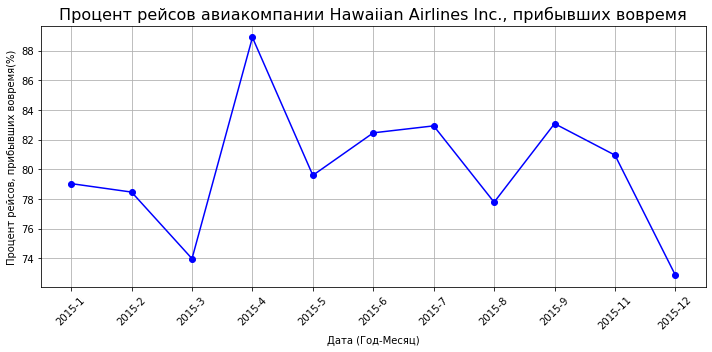

In [24]:
# Визуализируем
plt.figure(figsize=(10, 5))
plt.plot(monthly_stats['YEAR'].astype(str) + '-' + monthly_stats['MONTH'].astype(str),
         monthly_stats['PERCENT_ON_TIME'], marker='o', linestyle='-', color='b')
plt.title(f'Процент рейсов авиакомпании {most_punctual_airline["AIRLINE"]}, прибывших вовремя', fontsize=16)
plt.xlabel('Дата (Год-Месяц)', fontsize=10)
plt.ylabel('Процент рейсов, прибывших вовремя(%)', fontsize=10)
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

**На графике можно увидеть, что наибольший процент рейсов авиакомпании Hawaiian Airlines Inc., прибывших вовремя в Лос-Анджелес, наблюдается в апреле. Это может быть связано с нормализацией погодных условий и снижением туристического потока, что, в свою очередь, уменьшает количество факторов, способствующих задержкам вылетов и прилетов.**

__________________________________________________

# Найдем аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)

In [25]:
# Рассчитаем среднее время руления для каждого аэропорта
taxi_times = resulting_data.groupby('O_AIRPORT').agg({'TAXI_OUT': 'mean', 'TAXI_IN': 'mean'})

In [26]:
# Рассчитаем общее среднее время руления
taxi_times['AVERAGE_TAXI_TIME'] = taxi_times['TAXI_OUT'] + taxi_times['TAXI_IN']

In [27]:
# Найдем аэропорт с максимальным средним временем руления
most_taxi_time_airport = taxi_times['AVERAGE_TAXI_TIME'].idxmax()
most_taxi_time_value = taxi_times['AVERAGE_TAXI_TIME'].max()

In [28]:
most_taxi_time_airport, most_taxi_time_value

('Sawyer International Airport', 43.463414634146346)

In [29]:
# Найдем город, где находится найденный аэропорт
airport_info = resulting_data[resulting_data['O_AIRPORT'] == most_taxi_time_airport].iloc[0]

In [30]:
airport_info.head(10)

YEAR                   2015
MONTH                     1
DAY                       2
FLIGHT_NUMBER          2905
ORIGIN_AIRPORT          MQT
DESTINATION_AIRPORT     ORD
DEPARTURE_DELAY        -2.0
TAXI_OUT               21.0
TAXI_IN                60.0
ARRIVAL_DELAY          36.0
Name: 653151, dtype: object

In [31]:
print(f"Аэропорт с максимальным средним временем руления: {most_taxi_time_airport}. "f"Среднее время на рулении: {most_taxi_time_value:.2f} минут.")
print(f"Находится в городе - {airport_info['O_CITY']}.")

Аэропорт с максимальным средним временем руления: Sawyer International Airport. Среднее время на рулении: 43.46 минут.
Находится в городе - Marquette.


**Посмотрим среднее время руления по месяцам**

In [32]:
resulting_data['DEPARTURE_DATE'] = pd.to_datetime(resulting_data['dDATE'])

In [33]:
monthly_taxi_times = resulting_data.groupby([resulting_data['DEPARTURE_DATE'].dt.to_period('M')]).agg({'TAXI_OUT': 'mean', 'TAXI_IN': 'mean'})

In [34]:
# Рассчитываем общее среднее время руления
monthly_taxi_times['AVERAGE_TAXI_TIME'] = monthly_taxi_times['TAXI_OUT'] + monthly_taxi_times['TAXI_IN']

In [35]:
# Переименовываем индекс для удобства
monthly_taxi_times.index = monthly_taxi_times.index.astype(str)

In [36]:
monthly_taxi_times[['AVERAGE_TAXI_TIME']].head()

,AVERAGE_TAXI_TIME
DEPARTURE_DATE,
2015-01,26.430592
2015-02,27.046615
2015-03,25.203056
2015-04,24.864081
2015-05,24.990497


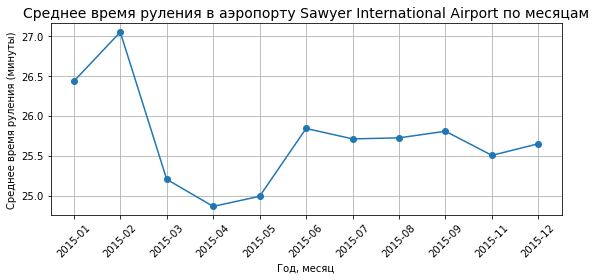

In [37]:
# Строим график
plt.figure(figsize=(8, 4))
plt.plot(monthly_taxi_times.index, monthly_taxi_times['AVERAGE_TAXI_TIME'], marker='o')
plt.title(f'Среднее время руления в аэропорту {most_taxi_time_airport} по месяцам', fontsize=14)
plt.xlabel('Год, месяц')
plt.ylabel('Среднее время руления (минуты)', fontsize=10)
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

**Время руления в аэропорту увеличивается в холодное время года. С февраля по апрель наблюдается резкое сокращение времени руления, что может свидетельствовать о зависимости этого показателя от погодных условий. Дополнительно можно отметить, что холодные условия могут замедлять работу наземных служб. Это может быть связано с необходимостью обработки взлетно-посадочных полос и рулежных дорожек от снега и льда. Также в зимний период могут происходить изменения в расписании рейсов, что также влияет на время руления. Например, задержки из-за плохих погодных условий могут накапливаться, создавая дополнительные очереди на рулежке. К тому же пилоты и экипажи могут проявлять большую осторожность при рулении в сложных погодных условиях, что также может увеличивать общее время руления**

_____________________________________________________

# Построим модель которая будет выбирать топ 3 аэропорта прилета(вероятность опоздания минимальная – RMSE метрика), в зависимости от аэропорта вылета


In [38]:
resulting_data.columns

Index(['YEAR', 'MONTH', 'DAY', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'DEPARTURE_DELAY', 'TAXI_OUT', 'TAXI_IN',
       'ARRIVAL_DELAY', 'AIRLINE', 'O_AIRPORT', 'O_CITY', 'dDATE', 'D_AIRPORT',
       'D_CITY', 'DEPARTURE_DATE'],
      dtype='object')

In [39]:
# Кодируем категориальные переменные
le_airport = LabelEncoder()
resulting_data['ORIGIN_AIRPORT_LABEL'] = le_airport.fit_transform(resulting_data['ORIGIN_AIRPORT'])
resulting_data['DESTINATION_AIRPORT_LABEL'] = le_airport.fit_transform(resulting_data['DESTINATION_AIRPORT'])

In [40]:
# Выбираем нужные признаки и целевую переменную
features = ['YEAR', 'MONTH', 'DAY', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT_LABEL', 'TAXI_OUT', 'TAXI_IN']
target = 'ARRIVAL_DELAY'

In [41]:
X_train, X_test, y_train, y_test = train_test_split(resulting_data[features], resulting_data[target], test_size=0.2, random_state=42)

In [42]:
# Создаем и обучаем модель
model = GradientBoostingRegressor()
model.fit(X_train, y_train)


GradientBoostingRegressor()

In [43]:
# Предсказываем задержки на тестовой выборке
y_pred = model.predict(X_test)

In [44]:
# Оцениваем модель
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 47.38600630925254


In [45]:
# Создаем функцию для получения топ-3 аэропортов прилета
def get_top_airports(origin_airport):
    # Фильтруем данные по выбранному аэропорту вылета
    filtered_data = resulting_data[resulting_data['ORIGIN_AIRPORT_LABEL'] == origin_airport]
    
    # Кодируем аэропорты назначения
    filtered_data['DESTINATION_AIRPORT_LABEL'] = le_airport.transform(filtered_data['DESTINATION_AIRPORT'])
    
    # Получаем признаки для предсказания
    X_predict = filtered_data[features].copy()
    X_predict['ORIGIN_AIRPORT_LABEL'] = origin_airport  # устанавливаем код аэропорта вылета
    
    # Предсказываем задержки
    predicted_delays = model.predict(X_predict)
    
    # Добавляем предсказанные задержки в DataFrame
    filtered_data['PREDICTED_DELAY'] = predicted_delays
    
    # Находим топ-3 аэропорта с минимальными предсказанными задержками
    top_airports = filtered_data.groupby('DESTINATION_AIRPORT_LABEL')['PREDICTED_DELAY'].mean().nsmallest(3)
    
    # Возвращаем оригинальные названия аэропортов и средние задержки
    return le_airport.inverse_transform(top_airports.index), top_airports.values

In [46]:
origin_airport_code = le_airport.transform(['ANC'])[0] 
top_airports, delays = get_top_airports(origin_airport_code)

C:\Users\acer\AppData\Local\Temp\ipykernel_10152\3479015066.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['DESTINATION_AIRPORT_LABEL'] = le_airport.transform(filtered_data['DESTINATION_AIRPORT'])
C:\Users\acer\AppData\Local\Temp\ipykernel_10152\3479015066.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['PREDICTED_DELAY'] = predicted_delays


In [49]:
# Выводим результаты
for airport, delay in zip(top_airports, delays):
    print(f'Аэропорт прилета: {airport}, Опоздание возможно на {delay:.2f} минут')

Аэропорт прилета: KOA, Опоздание возможно на 11.11 минут
Аэропорт прилета: ADK, Опоздание возможно на 12.02 минут
Аэропорт прилета: BET, Опоздание возможно на 12.30 минут


**В случае вылета рейса из аэропорта Ted Stevens Anchorage International Airport (ANC) минимальное опоздание возможно в следующие аэропорты прилета:**
- Kona International Airport at Keāhole (KOA), опоздание возможно на 11.11 минут, 
- Adak Airport (ADK), опоздание возможно на 12.02 минут,
- Bethel Airport (BET), опоздание возможно на 12.30 минут.